# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("/home/jovyan/work")

train_data = pd.read_csv('../data/raw/train.csv')
test_data = pd.read_csv('../data/raw/test.csv')
print(train_data.shape)
print(test_data.shape)

(8000, 22)
(3799, 21)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = MinMaxScaler()
# scaler = StandardScaler()

df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)

X_train, X_val, y_train, y_val = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42) #optional stratifiedshuffle: stratify=train_data_target

print(train_data.shape)
print(X_train.shape)
print(X_val.shape)

(8000, 22)
(6400, 19)
(1600, 19)


## Baseline Model: predict all 1s

ROC_AUC Score: 0.5
-----------
Confusion Matrix with thresthold of 0.8:
TN: 0, FP: 263
FN: 0, TP: 1337
1600 out of 1600 or 100% of players are predicted to be 5+ Yrs
-----------
Recall: 1.0
Accuracy: 0.8356
Balanced Accuracy: 0.5
F1: 0.9105
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.500


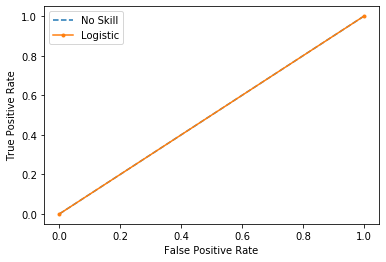

In [22]:
from src.visualization.visualize import eval_metrics

y_pred = np.full(shape=len(y_val), fill_value=1, dtype=np.int)
eval_metrics(y_pred, y_val, praba_threshold=0.8)

## Experiment 1: XGBoost 

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=2, random_state=0)
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=2, random_state=0)

ROC_AUC Score: 0.701
-----------
Confusion Matrix with thresthold of 0.8:
TN: 116, FP: 147
FN: 239, TP: 1098
1245 out of 1600 or 78% of players are predicted to be 5+ Yrs
-----------
Recall: 0.8212
Accuracy: 0.7588
Balanced Accuracy: 0.6312
F1: 0.8505
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.701


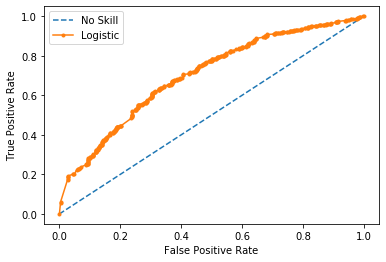

In [6]:
y_pred = clf.predict_proba(X_val)[:, 1]
eval_metrics(y_pred, y_val, praba_threshold=0.8)

In [8]:
binary_pred = clf.predict(X_val)
predx = binary_pred
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5+ Yrs')

1600 out of 1600 or 100% of players are predicted to be 5+ Yrs


In [9]:
submission = clf.predict_proba(test_data_x)[:,1]
submission = pd.DataFrame({'Id':test_data['Id'], 'TARGET_5Yrs':submission})
submission.to_csv("../data/submission/0206_xgb_base.csv", index=False)

## Experiment 2: XGB with different Sampling methods

Over sample with SMOTE

In [10]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: TARGET_5Yrs, dtype: float64

ROC_AUC Score: 0.682
-----------
Confusion Matrix with thresthold of 0.5:
TN: 177, FP: 86
FN: 502, TP: 835
921 out of 1600 or 58% of players are predicted to be 5+ Yrs
-----------
Recall: 0.6245
Accuracy: 0.6325
Balanced Accuracy: 0.6488
F1: 0.7396
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.682


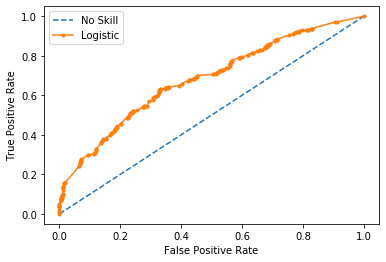

In [12]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=2, random_state=0).fit(X_sm, y_sm)
y_pred = clf.predict_proba(X_val)[:, 1]
eval_metrics(y_pred, y_val, praba_threshold=0.5)

Over sample with BorderlineSMOTE

In [14]:
from imblearn.over_sampling import BorderlineSMOTE
bsm = BorderlineSMOTE(random_state=42)
X_bsm, y_bsm = bsm.fit_resample(X_train, y_train)
print('\nBalance of positive and negative classes (%):')
y_bsm.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: TARGET_5Yrs, dtype: float64

ROC_AUC Score: 0.683
-----------
Confusion Matrix with thresthold of 0.5:
TN: 163, FP: 100
FN: 490, TP: 847
947 out of 1600 or 59% of players are predicted to be 5+ Yrs
-----------
Recall: 0.6335
Accuracy: 0.6312
Balanced Accuracy: 0.6266
F1: 0.7417
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.683


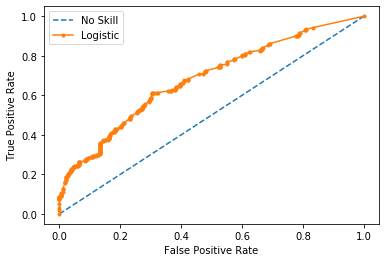

In [16]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=2, random_state=0)
clf.fit(X_bsm, y_bsm)
y_pred = clf.predict_proba(X_val)[:, 1]
eval_metrics(y_pred, y_val, praba_threshold=0.5)

Combined sample with SMOTETomek

In [17]:
from imblearn.combine import SMOTETomek 
bsm = SMOTETomek(random_state=42)
X_sme, y_sme = bsm.fit_resample(X_train, y_train)
print('\nBalance of positive and negative classes (%):')
y_sme.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: TARGET_5Yrs, dtype: float64

ROC_AUC Score: 0.683
-----------
Confusion Matrix with thresthold of 0.5:
TN: 177, FP: 86
FN: 504, TP: 833
919 out of 1600 or 57% of players are predicted to be 5+ Yrs
-----------
Recall: 0.623
Accuracy: 0.6312
Balanced Accuracy: 0.648
F1: 0.7385
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.683


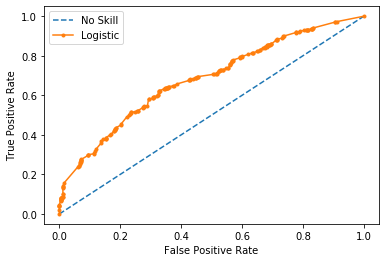

In [18]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=2, random_state=0)
clf.fit(X_sme, y_sme)
y_pred = clf.predict_proba(X_val)[:, 1]
eval_metrics(y_pred, y_val, praba_threshold=0.5)

## Experiment 3: XGBoost with Random Search CV + SMOTE (val auc: 0.638 | test auc: 0.538) 

In [62]:
from xgboost import XGBClassifier as xgbc
from sklearn.calibration import CalibratedClassifierCV

max_depth =[1, 2, 3, 5, 7]

for md in max_depth:
    clf = xgbc(objective='binary:logistic', learning_rate=0.1, n_estimators=150, max_depth=md, n_jobs=-1, random_state=0, eval_metric='auc', use_label_encoder=False).fit(X_sm, y_sm)
    calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=5).fit(X_sm, y_sm)
    y_pred = calibrated_clf.predict_proba(X_val)[:,1]
    roc_score = round(roc_auc_score(y_val, y_pred),3)
    print(f'Max Depth: {md}, ROC AUC Score: {roc_score}')

Max Depth: 1, ROC AUC Score: 0.695
Max Depth: 2, ROC AUC Score: 0.687
Max Depth: 3, ROC AUC Score: 0.685
Max Depth: 5, ROC AUC Score: 0.658
Max Depth: 7, ROC AUC Score: 0.649


In [ ]:
eta = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

for e in eta:
    clf = xgbc(objective='binary:logistic', eta=e, learning_rate=0.1, n_estimators=150, max_depth=1, n_jobs=-1, random_state=0, subsample=0.8, eval_metric='auc', use_label_encoder=False).fit(X_sm, y_sm)
    calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=5).fit(X_sm, y_sm)
    y_pred = calibrated_clf.predict_proba(X_val)[:,1]
    roc_score = round(roc_auc_score(y_val, y_pred),3)
    print(f'eta: {e}, ROC AUC Score: {roc_score}')

In [ ]:
gamma=[0.0, 0.1, 0.2 , 0.3, 0.4]

for g in gamma:
    clf = xgbc(objective='binary:logistic', learning_rate=0.1, n_estimators=150, max_depth=1, n_jobs=-1, random_state=0, subsample=0.8, eval_metric='auc', use_label_encoder=False).fit(X_sm, y_sm)
    calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=5).fit(X_sm, y_sm)
    y_pred = calibrated_clf.predict_proba(X_val)[:,1]
    roc_score = round(roc_auc_score(y_val, y_pred),3)
    print(f'gamma: {g}, ROC AUC Score: {roc_score}')

In [ ]:
model.predict()

In [19]:
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_sm, y_sm)

GradientBoostingClassifier(random_state=42)

In [20]:
param_grid = {
        'max_depth': [1, 2, 3, 5],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
        'n_estimators': [50, 100, 150, 200]}

In [37]:
from src.visualization.visualize import plot_roc_curve
from sklearn.metrics import roc_auc_score

max_depth =[1, 2, 3, 5, 7]

for md in max_depth:
    xgb_rcv = GradientBoostingClassifier(max_depth=md, random_state=42).fit(X_sm, y_sm)
    y_pred = xgb_rcv.predict_proba(X_val)[:,1]
    roc_score = round(roc_auc_score(y_val, y_pred),3)
    print(f'Max Depth: {md}, ROC AUC Score: {roc_score}')

Max Depth: 1, ROC AUC Score: 0.696
Max Depth: 2, ROC AUC Score: 0.688
Max Depth: 3, ROC AUC Score: 0.689
Max Depth: 5, ROC AUC Score: 0.678


In [39]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

for lr in learning_rate:
    xgb_rcv = GradientBoostingClassifier(learning_rate=lr, max_depth=1, random_state=42).fit(X_sm, y_sm)
    y_pred = xgb_rcv.predict_proba(X_val)[:,1]
    roc_score = round(roc_auc_score(y_val, y_pred),3)
    print(f'Learn rate: {lr}, ROC AUC Score: {roc_score}')

Learn rate: 0.0001, ROC AUC Score: 0.62
Learn rate: 0.001, ROC AUC Score: 0.626
Learn rate: 0.01, ROC AUC Score: 0.674
Learn rate: 0.1, ROC AUC Score: 0.696
Learn rate: 0.2, ROC AUC Score: 0.695
Learn rate: 0.3, ROC AUC Score: 0.691
Learn rate: 0.4, ROC AUC Score: 0.692
Learn rate: 0.5, ROC AUC Score: 0.694


In [42]:
subsample = [0.5, 0.6, 0.7, 0.8, 0.9]

for ss in subsample:
    xgb_rcv = GradientBoostingClassifier(subsample=ss, learning_rate=0.1, max_depth=1, random_state=42).fit(X_sm, y_sm)
    y_pred = xgb_rcv.predict_proba(X_val)[:,1]
    roc_score = round(roc_auc_score(y_val, y_pred),3)
    print(f'Subsample: {ss}, ROC AUC Score: {roc_score}')

Subsample: 0.5, ROC AUC Score: 0.694
Subsample: 0.6, ROC AUC Score: 0.695
Subsample: 0.7, ROC AUC Score: 0.696
Subsample: 0.8, ROC AUC Score: 0.697
Subsample: 0.9, ROC AUC Score: 0.695


In [43]:
n_estimators = [25, 50, 75, 100, 125, 150, 175, 200]

for ne in n_estimators:
    xgb_rcv = GradientBoostingClassifier(n_estimators=ne, subsample=0.8, learning_rate=0.1, max_depth=1, random_state=42).fit(X_sm, y_sm)
    y_pred = xgb_rcv.predict_proba(X_val)[:,1]
    roc_score = round(roc_auc_score(y_val, y_pred),3)
    print(f'n_est: {ne}, ROC AUC Score: {roc_score}')

n_est: 25, ROC AUC Score: 0.687
n_est: 50, ROC AUC Score: 0.696
n_est: 75, ROC AUC Score: 0.697
n_est: 100, ROC AUC Score: 0.697
n_est: 125, ROC AUC Score: 0.697
n_est: 150, ROC AUC Score: 0.698
n_est: 175, ROC AUC Score: 0.697
n_est: 200, ROC AUC Score: 0.696


ROC_AUC Score: 0.698
-----------
Confusion Matrix with thresthold of 0.5:
TN: 166, FP: 97
FN: 453, TP: 884
981 out of 1600 or 61% of players are predicted to be 5+ Yrs
-----------
Recall: 0.6612
Accuracy: 0.6562
Balanced Accuracy: 0.6462
F1: 0.7627
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.698


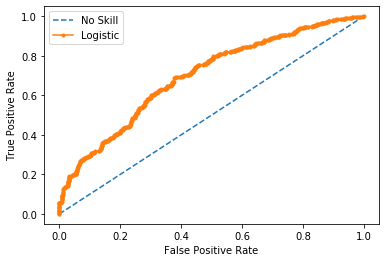

In [45]:
xgb_rcv = GradientBoostingClassifier(n_estimators=150, subsample=0.8, learning_rate=0.1, max_depth=1, random_state=42).fit(X_sm, y_sm)
y_pred = xgb_rcv.predict_proba(X_val)[:,1]

eval_metrics(y_pred, y_val, praba_threshold=0.5)

In [21]:
from sklearn.model_selection import RandomizedSearchCV
xgb_rcv = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='roc_auc')
xgb_rcv.fit(X_sm, y_sm)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 15,
                                                      20],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [27]:
xgb_rcv.best_params_

{'subsample': 0.6, 'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.3}

ROC_AUC Score: 0.651
-----------
Confusion Matrix with thresthold of 0.8:
TN: 39, FP: 224
FN: 89, TP: 1248
1472 out of 1600 or 92% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9334
Accuracy: 0.8044
Balanced Accuracy: 0.5409
F1: 0.8886
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.651


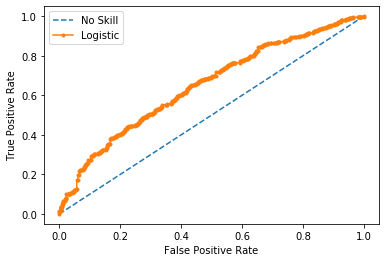

In [29]:
pred = xgb_rcv.predict_proba(X_val)[:,1]
eval_metrics(pred, y_val, praba_threshold=0.8)

In [47]:
submission = xgb_rcv.predict_proba(test_data_x)[:,1]
submission = pd.DataFrame({'Id':test_data['Id'], 'TARGET_5Yrs':submission})
submission.to_csv("../data/submission/0206_xgb_pred.csv", index=False)

## Experiment 4: reduce features

In [26]:
X_sm_reduced = X_sm[['GP', 'FG%', '3P%', 'FT%']]
X_sm_reduced.head()

,GP,FG%,3P%,FT%
0,0.664122,0.917211,0.447761,0.463776
1,0.694656,0.607843,0.494196,0.497256
2,0.732824,0.655773,0.471808,0.420966
3,0.351145,0.490196,0.135158,0.384742
4,0.458015,0.461874,0.499171,0.443469
